In [1]:
import os
import json
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

from src.data_loader import Shifted_Data_Loader
from src.plot import orig_vs_transformed as plot_ovt
from src.plot import enc_dec_samples
from src.models import TandemVAEBuilder
from src.config import get_config
from src.trainer import Trainer
from src.utils import prepare_dirs_and_logger
from keras.datasets import fashion_mnist

Using TensorFlow backend.


In [2]:
config,_ = get_config()
setattr(config, 'batch_size', 128)
setattr(config, 'dataset', 'mnist')
setattr(config, 'epochs', 5)
setattr(config, 'enc_layers', [3000,2000])
setattr(config, 'z_dim', 2)
setattr(config, 'recon',10)
setattr(config, 'log_dir', '../logs')
prepare_dirs_and_logger(config)
vars(config)

{'batch_size': 128,
 'data_dir': 'data',
 'dataset': 'mnist',
 'enc_layers': [3000, 2000],
 'epochs': 5,
 'log_dir': '../logs',
 'log_level': 'INFO',
 'model_dir': '../logs/mnist_1008_112539',
 'model_name': 'mnist_1008_112539',
 'optimizer': 'adam',
 'recon': 10,
 'xcov': 10,
 'xent': 10,
 'y_dim': 10,
 'z_dim': 2}

In [3]:
with open(os.path.join(config.model_dir,'params.json'), 'w') as fp:
    json.dump(vars(config), fp)

In [4]:
DL = Shifted_Data_Loader(dataset=config.dataset,
                         rotation=None,
#                          translation=None,
                        )

dataset:  mnist
scale:  2
tx_max:  0.75
rot_max:  None
loading mnist...


  5%|▍         | 2946/60000 [00:00<00:01, 29445.64it/s]

making training data...


 75%|███████▌  | 7546/10000 [00:00<00:00, 37718.93it/s]

making testing data...


100%|██████████| 10000/10000 [00:00<00:00, 37537.93it/s]


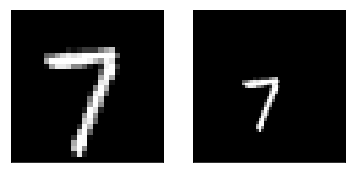

In [5]:
pt,idx = plot_ovt(DL,cmap='gray')

In [6]:
mod_builder = TandemVAEBuilder(enc_layers=config.enc_layers,z_dim=config.z_dim)

In [7]:
trainer = Trainer(config,DL,mod_builder)

building model...


In [8]:
trainer.compile_model()

In [9]:
trainer.go(DL.sx_train,DL.y_train_oh,verbose=0)

In [10]:
trainer.save_model()

In [11]:
from keras.models import Model
from keras.layers import Input

In [12]:
z_encoder = trainer.get_encoder('z_lat')
classifier = trainer.get_encoder('y_lat')
decoder_inp = Input(shape=(config.y_dim+config.z_dim,))
dec_layers = trainer.model.layers[-3:]
_gen_x = dec_layers[0](decoder_inp)
_gen_x = dec_layers[1](_gen_x)
_gen_x = dec_layers[2](_gen_x)
generator = Model(decoder_inp,_gen_x)

In [13]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2000)              26000     
_________________________________________________________________
dense_4 (Dense)              (None, 3000)              6003000   
_________________________________________________________________
reconstruction (Dense)       (None, 3136)              9411136   
Total params: 15,440,136
Trainable params: 15,440,136
Non-trainable params: 0
_________________________________________________________________


In [14]:
# classifier.compile(loss='mse',optimizer='adam')
# classifier.evaluate(DL.sx_test,batch_size=config.batch_size)

In [15]:
z_enc = z_encoder.predict(DL.sx_test,batch_size=config.batch_size)
y_class = classifier.predict(DL.sx_test,batch_size=config.batch_size)

In [16]:
z_enc.shape

(10000, 2)

In [17]:
_lat_vec = np.concatenate([y_class,z_enc],axis=1)
_lat_vec.shape

(10000, 12)

In [18]:
regen = generator.predict(_lat_vec,batch_size=config.batch_size)

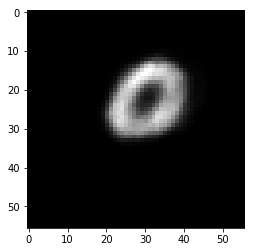

In [19]:
rand_im = np.random.randint(0,10000)
plt.imshow(regen[rand_im].reshape(56,56),cmap='gray')

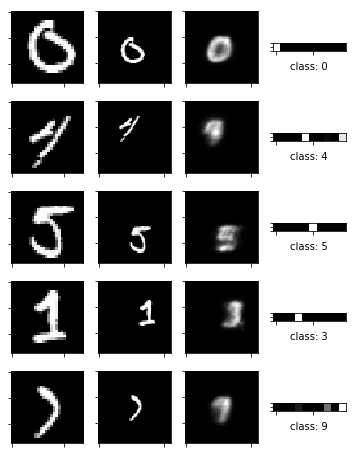

In [20]:
enc_dec_samples(DL.x_test,DL.sx_test,z_enc,y_class,generator)

In [21]:
# plt.

In [22]:
from src.metrics import var_expl
dxs = DL.dx[1]-14
dys = DL.dy[1]-14
dtheta = DL.dtheta[1]
fve_dx = var_expl(features=z_enc,cond=dxs,bins=21)
fve_dy = var_expl(features=z_enc,cond=dys,bins=21)
fve_dt = var_expl(features=z_enc,cond=dtheta,bins=21)

In [23]:
fve_dx_norm = (dxs.var()-fve_dx)/dxs.var()
fve_dy_norm = (dys.var()-fve_dy)/dys.var()
fve_dth_norm = (dtheta.var()-fve_dt)/dtheta.var()

/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [24]:
import seaborn as sns
sns.set_context('talk')

In [25]:
fve_dx_norm.shape

(21, 2)

0

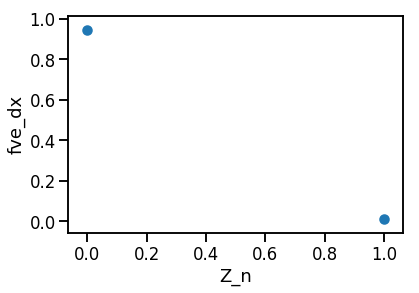

In [26]:
plt.scatter(np.arange(config.z_dim),fve_dx_norm.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_dx')
# plt.ylim(-0.125,0.25)
np.argmax(fve_dx_norm.mean(axis=0))

In [27]:
fve_dy_norm.mean(axis=0)

array([-0.0153358 ,  0.94939574])

1

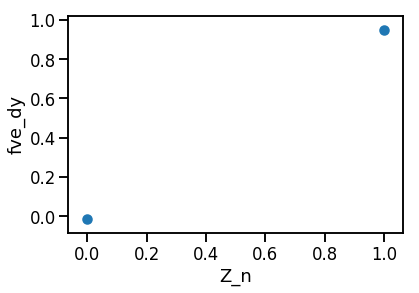

In [28]:
plt.scatter(np.arange(config.z_dim),fve_dy_norm.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_dy')
# plt.ylim(-0.125,0.25)
np.argmax(fve_dy_norm.mean(axis=0))

0

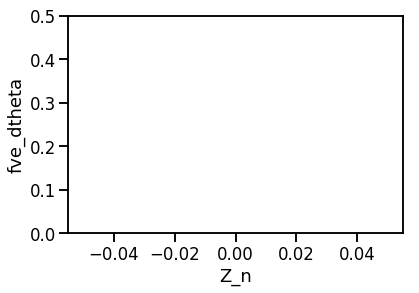

In [29]:
plt.scatter(np.arange(config.z_dim),fve_dth_norm.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_dtheta')
plt.ylim(0.0,0.5)
np.argmax(fve_dth_norm.mean(axis=0))

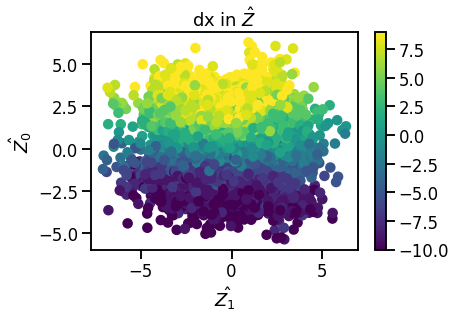

In [30]:
from src.plot import Z_color_scatter
Z_color_scatter(z_enc,[1,0],dxs)

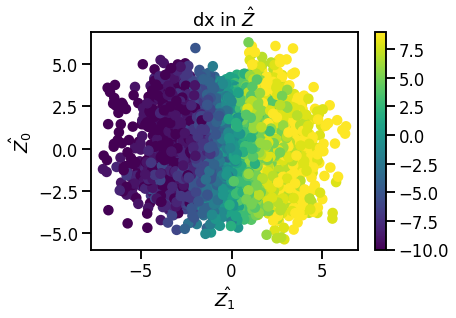

In [31]:
Z_color_scatter(z_enc,[1,0],dys)

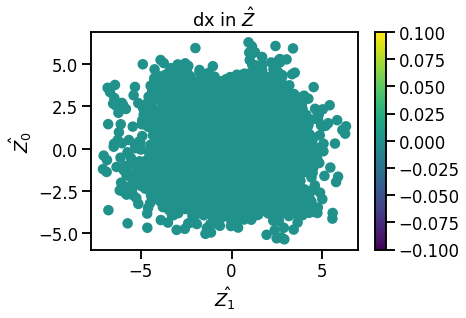

In [32]:
Z_color_scatter(z_enc,[1,0],dtheta)